In [9]:
import numpy as np
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import backend as K
from glob import glob
from PIL import Image

# Parametry dla patches
PATCH_SIZE = 256  # Rozmiar pojedynczego non-overlapping patch
ORIGINAL_SIZE = 2048  # Oryginalny rozmiar obrazu


In [10]:
def extract_non_overlapping_patches(image, patch_size=256):
    """
    Ekstraktuje non-overlapping patches z obrazu
    """
    patches = []
    positions = []
    
    h, w = image.shape[:2]
    
    # Oblicz ile patches zmieści się w każdym kierunku
    num_patches_h = h // patch_size
    num_patches_w = w // patch_size
    
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            y = i * patch_size
            x = j * patch_size
            
            if len(image.shape) == 3:
                patch = image[y:y+patch_size, x:x+patch_size, :]
            else:
                patch = image[y:y+patch_size, x:x+patch_size]
            
            patches.append(patch)
            positions.append((y, x))
    
    return np.array(patches), positions, (num_patches_h, num_patches_w)

def reconstruct_from_non_overlapping_patches(patches, positions, patch_grid, patch_size=256):
    """
    Rekonstruuje obraz z non-overlapping patches
    """
    num_patches_h, num_patches_w = patch_grid
    
    if len(patches[0].shape) == 3:
        reconstructed = np.zeros((num_patches_h * patch_size, num_patches_w * patch_size, patches[0].shape[2]), dtype=np.float32)
    else:
        reconstructed = np.zeros((num_patches_h * patch_size, num_patches_w * patch_size), dtype=np.float32)
    
    for i, (patch, (y, x)) in enumerate(zip(patches, positions)):
        if len(patch.shape) == 3:
            reconstructed[y:y+patch_size, x:x+patch_size, :] = patch
        else:
            reconstructed[y:y+patch_size, x:x+patch_size] = patch.squeeze()
    
    return reconstructed

def pad_image_to_patch_size(image, patch_size=256):
    """
    Dodaje padding żeby obraz był podzielny przez rozmiar patch
    """
    h, w = image.shape[:2]
    
    # Oblicz potrzebny padding
    pad_h = (patch_size - (h % patch_size)) % patch_size
    pad_w = (patch_size - (w % patch_size)) % patch_size
    
    if len(image.shape) == 3:
        padded = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
    else:
        padded = np.pad(image, ((0, pad_h), (0, pad_w)), mode='reflect')
    
    return padded, (h, w)

def remove_padding(image, original_shape):
    """
    Usuwa padding z zrekonstruowanego obrazu
    """
    h, w = original_shape
    return image[:h, :w]


In [11]:
def read_and_process_image_patches(image_path):
    """
    Wczytuje obraz i dzieli na non-overlapping patches
    """
    img = cv2.imread(f'all/images/{image_path}.jpg')
    img = img.astype(np.float32)
    img = img / 255.0
    img = cv2.resize(img, (ORIGINAL_SIZE, ORIGINAL_SIZE), interpolation=cv2.INTER_LINEAR)
    
    # Dodaj padding jeśli potrzeba
    padded_img, original_shape = pad_image_to_patch_size(img, PATCH_SIZE)
    
    # Ekstraktuj non-overlapping patches
    patches, positions, patch_grid = extract_non_overlapping_patches(padded_img, PATCH_SIZE)
    
    return patches, positions, patch_grid, original_shape, padded_img.shape

def read_mask_patches(image_name):
    """
    Wczytuje maskę i dzieli na non-overlapping patches
    """
    mask = cv2.imread(f'all/manual1/{image_name}.tif', cv2.IMREAD_GRAYSCALE)
    mask = mask.astype(np.float32)
    mask = mask / 255.0
    mask = cv2.resize(mask, (ORIGINAL_SIZE, ORIGINAL_SIZE), interpolation=cv2.INTER_LINEAR)
    
    # Dodaj padding jeśli potrzeba
    padded_mask, original_shape = pad_image_to_patch_size(mask, PATCH_SIZE)
    
    # Ekstraktuj non-overlapping patches
    patches, positions, patch_grid = extract_non_overlapping_patches(padded_mask, PATCH_SIZE)
    
    return patches, positions, patch_grid, original_shape, padded_mask.shape


In [12]:
# Przygotowanie danych patch-based
image_names = ['06_g', '02_g', '03_g', '04_g', '05_g']

all_image_patches = []
all_mask_patches = []
patch_info = []  # Informacje o patchach dla każdego obrazu

for name in image_names:
    img_patches, img_positions, img_patch_grid, img_original_shape, img_padded_shape = read_and_process_image_patches(name)
    mask_patches, mask_positions, mask_patch_grid, mask_original_shape, mask_padded_shape = read_mask_patches(name)
    
    all_image_patches.extend(img_patches)
    all_mask_patches.extend(mask_patches)
    
    patch_info.append({
        'name': name,
        'positions': img_positions,
        'patch_grid': img_patch_grid,
        'original_shape': img_original_shape,
        'padded_shape': img_padded_shape
    })

# Konwersja na numpy arrays
all_image_patches = np.array(all_image_patches)
all_mask_patches = np.array(all_mask_patches)

print(f"Liczba patches: {len(all_image_patches)}")
print(f"Rozmiar patch: {all_image_patches.shape}")
print(f"Patches na obraz: {len(all_image_patches) // len(image_names)}")

# Podział na zbiory treningowe i walidacyjne
X_train, X_valid, Y_train, Y_valid = train_test_split(
    all_image_patches, all_mask_patches, test_size=0.33, random_state=42
)


Liczba patches: 320
Rozmiar patch: (320, 256, 256, 3)
Patches na obraz: 64


In [13]:
# Parametry dla patch-based modelu
input_shape_patch = [PATCH_SIZE, PATCH_SIZE, 3]

# Model base
base_model = tf.keras.applications.MobileNetV2(input_shape_patch, include_top=False)

layer_names = [
    'block_1_expand_relu',   # 128x128 dla patch 256x256
    'block_3_expand_relu',   # 64x64
    'block_6_expand_relu',   # 32x32
    'block_13_expand_relu',  # 16x16
    'block_16_project',      # 8x8
]
layers = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 8x8 -> 16x16
    pix2pix.upsample(256, 3),  # 16x16 -> 32x32
    pix2pix.upsample(128, 3),  # 32x32 -> 64x64
    pix2pix.upsample(64, 3),   # 64x64 -> 128x128
]

def unet_model_patches(output_channels):
    inputs = tf.keras.layers.Input(shape=input_shape_patch)
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same', activation='sigmoid'
    )
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

# Dice coefficient
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Kompilacja modelu
OUTPUT_CLASSES = 1
model = unet_model_patches(output_channels=OUTPUT_CLASSES)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=[dice_coef]
)

# Uczenie modelu na patches
print("Rozpoczynanie treningu na patches...")
history = model.fit(
    X_train, Y_train, 
    validation_data=(X_valid, Y_valid), 
    epochs=20,
    batch_size=8  # Mniejszy batch size dla patches
)


/var/folders/5x/6grr61gd1fv_14f2c7m11pqh0000gn/T/ipykernel_36642/1753433410.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape_patch, include_top=False)


Rozpoczynanie treningu na patches...
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 615ms/step - dice_coef: 0.1074 - loss: 0.2907 - val_dice_coef: 0.1293 - val_loss: 0.2170
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 600ms/step - dice_coef: 0.3379 - loss: 0.1312 - val_dice_coef: 0.2437 - val_loss: 0.1974
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 615ms/step - dice_coef: 0.5244 - loss: 0.0984 - val_dice_coef: 0.3425 - val_loss: 0.1427
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 622ms/step - dice_coef: 0.5536 - loss: 0.0928 - val_dice_coef: 0.4489 - val_loss: 0.1255
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 632ms/step - dice_coef: 0.5905 - loss: 0.0878 - val_dice_coef: 0.4950 - val_loss: 0.1281
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 651ms/step - dice_coef: 0.5943 - loss: 0.0880 - val_dice_coef: 0.5685 - val_loss: 0.1011
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 656ms/step - dice_coef: 0.6040 - loss: 0.0849 - val_dice_coef: 0.5800 - val_loss: 0.0972
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 647m

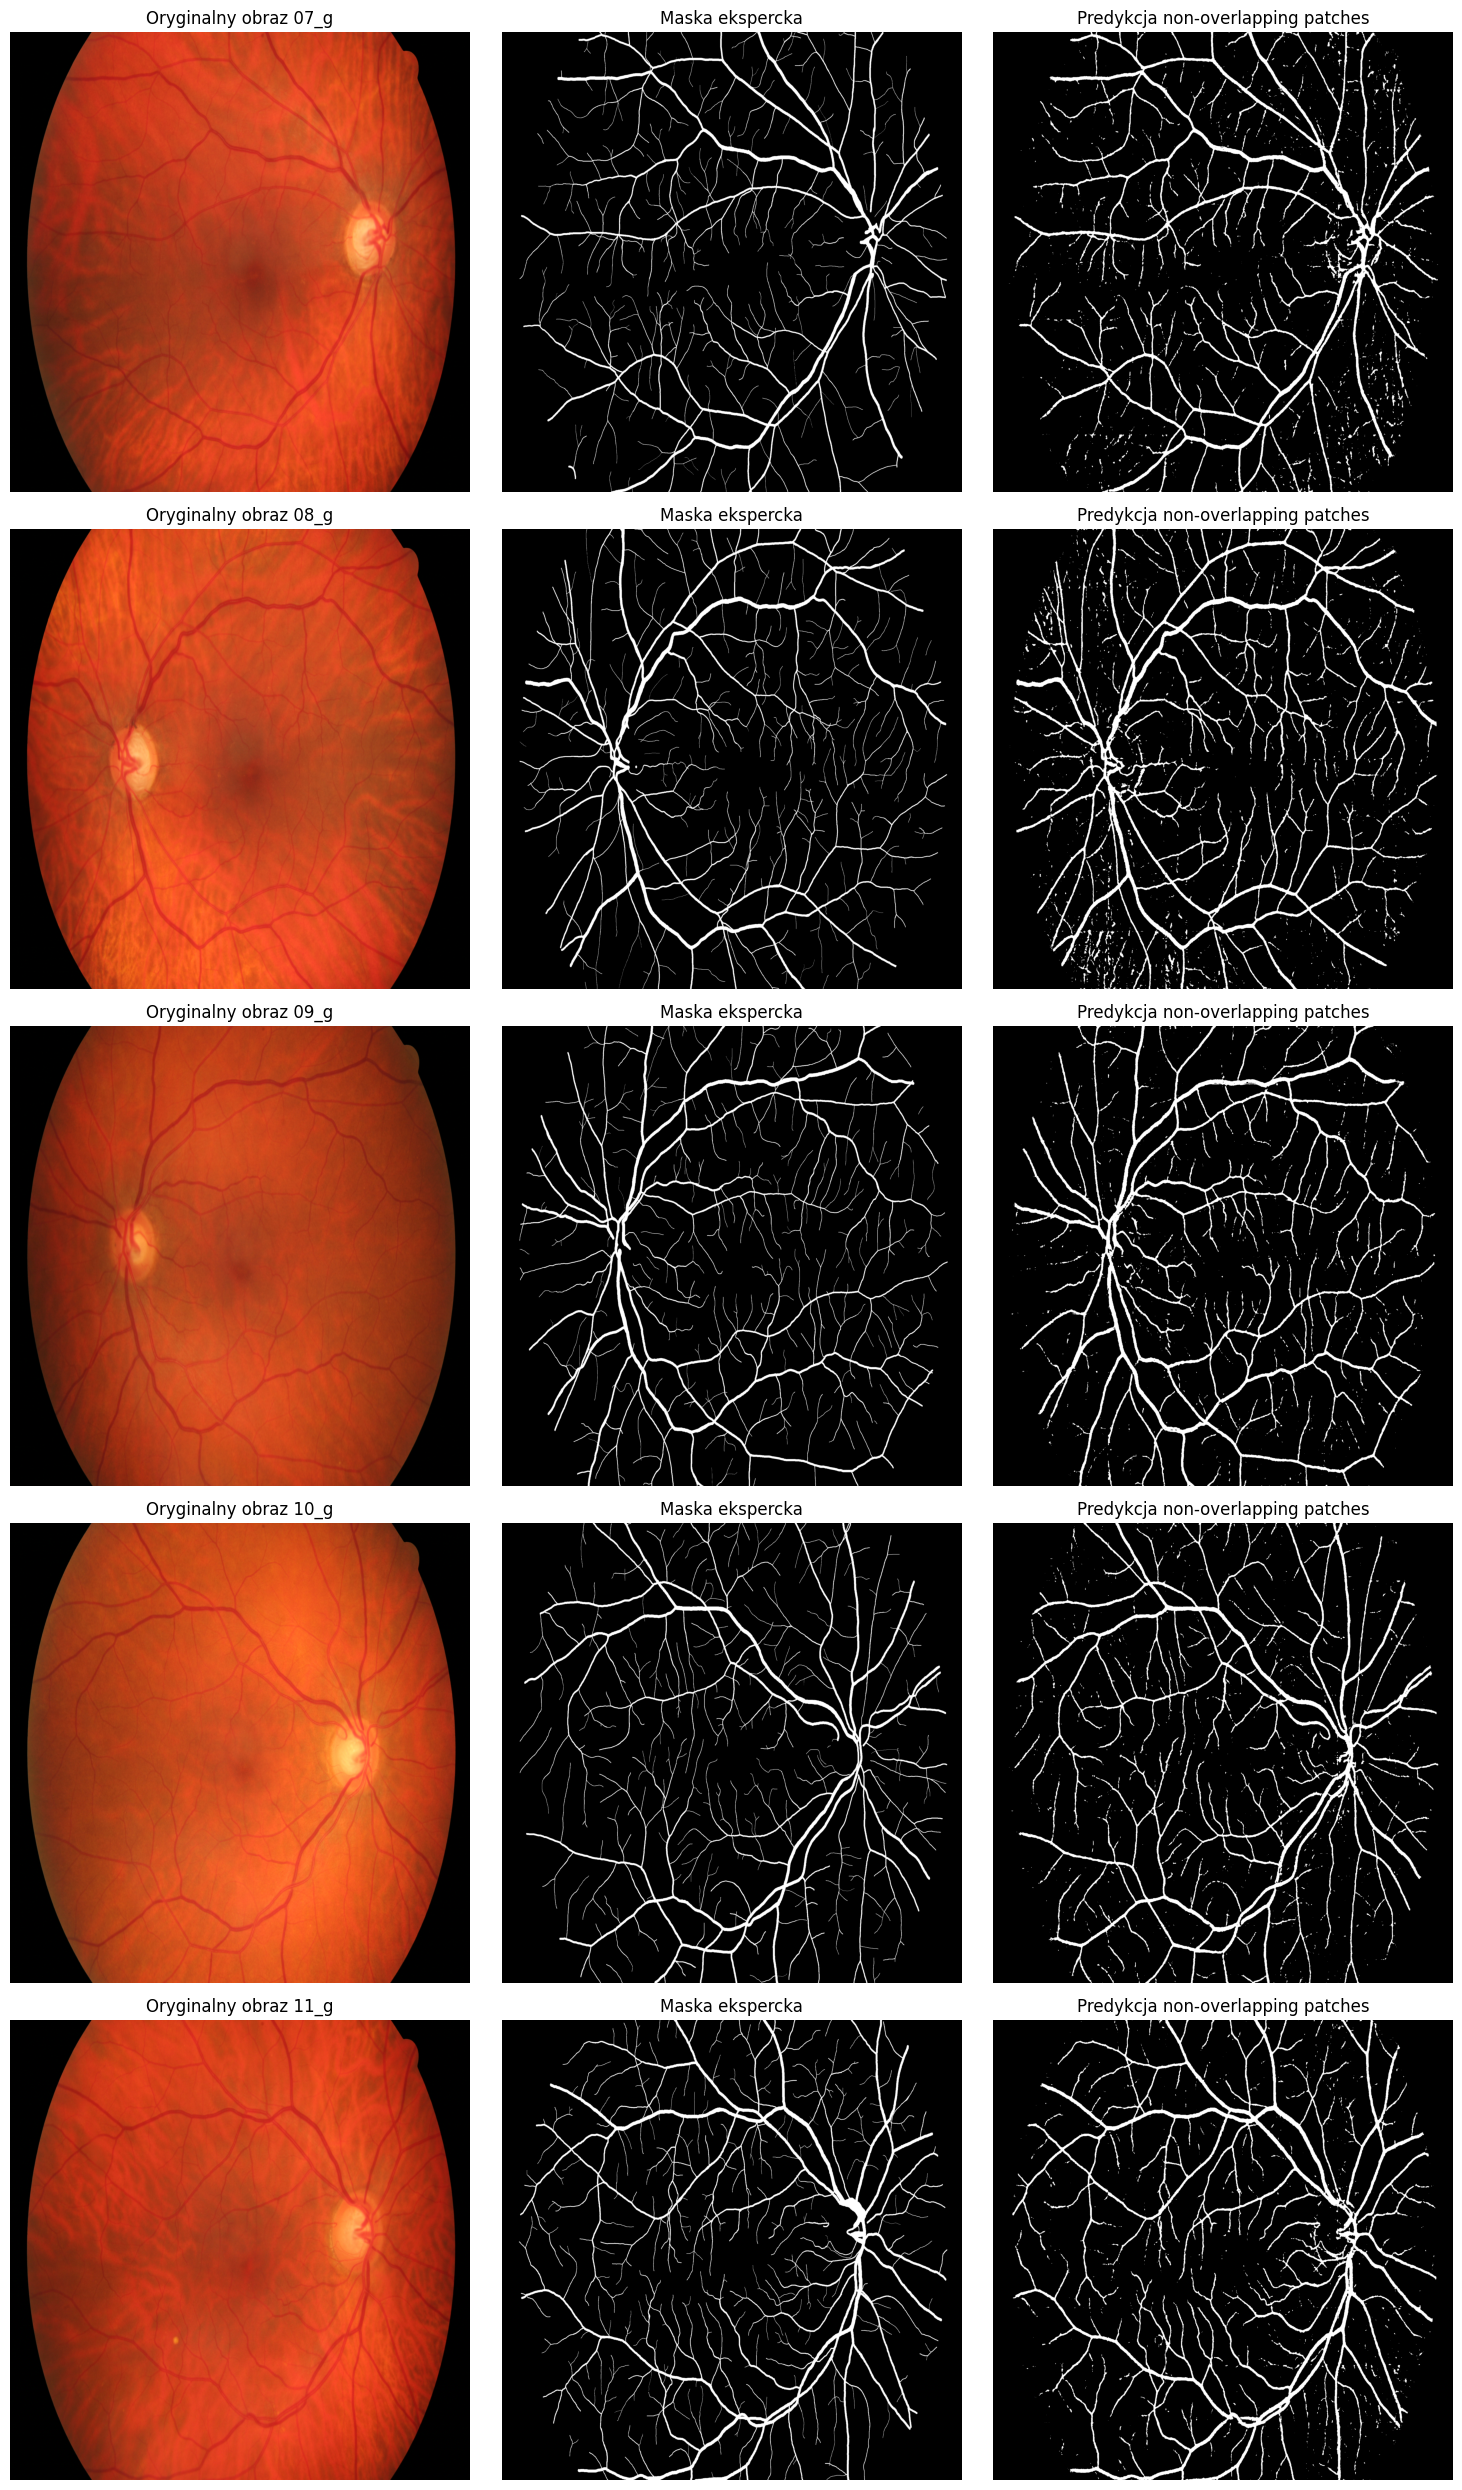

In [14]:
def predict_full_image_from_patches(image_path, model, threshold=0.14):
    """
    Predykcja dla całego obrazu używając non-overlapping patches
    """
    img_patches, positions, patch_grid, original_shape, padded_shape = read_and_process_image_patches(image_path)
    
    # Predykcja dla wszystkich patches
    predictions = model.predict(img_patches, verbose=0)
    pred_masks = (predictions > threshold).astype(np.float32)
    
    # Rekonstrukcja pełnego obrazu
    full_prediction = reconstruct_from_non_overlapping_patches(
        pred_masks, positions, patch_grid, PATCH_SIZE
    )
    
    # Usuń padding
    final_result = remove_padding(full_prediction, original_shape)
    
    return final_result

# Testowanie na nowych obrazach
test_image_names = ['07_g', '08_g', '09_g', '10_g', '11_g']

plt.figure(figsize=(15, len(test_image_names) * 5))

for i, name in enumerate(test_image_names):
    # Oryginalny obraz
    original_img = cv2.imread(f'all/images/{name}.jpg')
    original_img = cv2.resize(original_img, (ORIGINAL_SIZE, ORIGINAL_SIZE))
    original_img = original_img.astype(np.float32) / 255.0
    
    # Maska ekspercka
    expert_mask = cv2.imread(f'all/manual1/{name}.tif', cv2.IMREAD_GRAYSCALE)
    expert_mask = cv2.resize(expert_mask, (ORIGINAL_SIZE, ORIGINAL_SIZE))
    expert_mask = expert_mask.astype(np.float32) / 255.0
    
    # Predykcja patch-based
    predicted_mask = predict_full_image_from_patches(name, model)
    
    # Wyświetlanie
    plt.subplot(len(test_image_names), 3, i * 3 + 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Oryginalny obraz {name}")
    plt.axis('off')
    
    plt.subplot(len(test_image_names), 3, i * 3 + 2)
    plt.imshow(expert_mask, cmap='gray')
    plt.title("Maska ekspercka")
    plt.axis('off')
    
    plt.subplot(len(test_image_names), 3, i * 3 + 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predykcja non-overlapping patches")
    plt.axis('off')

plt.tight_layout()
plt.show()
